# CROP-seq KO150 -  Guide Assignment, Filtering, Normalization, Confounding Factor Analysis and Unsupervised Analysis
- input: cellranger output ie raw counts
- output: PCA & UMAP plots

In [1]:
# set correct working directory -> project folder
getwd()
setwd('..')
getwd()

[1] "/home/sreichl/projects/bmdm-stim/src"

[1] "/home/sreichl/projects/bmdm-stim"

In [2]:
# load libraries

# for Seurat (limma via conda install)
library(dplyr)
library(Seurat) # installed via conda install (conda forge channel)
library(patchwork)
library(ggplot2)
library(DESeq2)
library(cowplot)
library(glmGamPoi) # for faster sctransform

# for gene list converter
library(biomaRt)

# for Upset plots
library(UpSetR)
library(fastDummies)

# for volcano plots
library(EnhancedVolcano)

library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, 

In [3]:
# configs
# TODO: Change this path to YOUR CellRanger output path
data_path_prefix <- '/nobackup/lab_bsf/projects/BSA_0331_PT_ANTIBODY_HASH/OUT/COUNT/'

data_sets <- c('CROPseq_KO150_A1_transcriptome',
               'CROPseq_KO150_A2_transcriptome',
               'CROPseq_KO150_A3_transcriptome',
               'CROPseq_KO150_B1_transcriptome',
               'CROPseq_KO150_B2_transcriptome',
               'CROPseq_KO150_B3_transcriptome',
               'CROPseq_KO150_C1_transcriptome',
               'CROPseq_KO150_C2_transcriptome',
               'CROPseq_KO150_C3_transcriptome'
              )

results_path <- file.path('results','KO150')

In [4]:
# make directories if not exist
dir.create(results_path, showWarnings = FALSE)

# load & merge data

In [34]:
for (data_set in data_sets){
    # Load the dataset
    tmp_data <- Read10X(data.dir = file.path(data_path_prefix, data_set, "filtered_feature_bc_matrix"))
    
    # Initialize the Seurat object with the raw (non-normalized data).
    tmp_Seurat <- CreateSeuratObject(counts = tmp_data$'Gene Expression', project =data_set)

    # create a new assay to store Antibody information
    tmp_Seurat[["AB"]] <- CreateAssayObject(counts = tmp_data$'Antibody Capture')

    # create a new assay to store guide information
    tmp_Seurat[["gRNA"]] <- CreateAssayObject(counts = tmp_data$'CRISPR Guide Capture')

    # create a new assay to store HTO information
    tmp_Seurat[["HTO"]] <- CreateAssayObject(counts = tmp_data$'Custom')
    
    switch(  
        data_set,
        'CROPseq_KO150_A1_transcriptome'=KO150_A1<-tmp_Seurat,
        'CROPseq_KO150_A2_transcriptome'=KO150_A2<-tmp_Seurat,
        'CROPseq_KO150_A3_transcriptome'=KO150_A3<-tmp_Seurat,
        'CROPseq_KO150_B1_transcriptome'=KO150_B1<-tmp_Seurat,
        'CROPseq_KO150_B2_transcriptome'=KO150_B2<-tmp_Seurat,
        'CROPseq_KO150_B3_transcriptome'=KO150_B3<-tmp_Seurat,
        'CROPseq_KO150_C1_transcriptome'=KO150_C1<-tmp_Seurat,
        'CROPseq_KO150_C2_transcriptome'=KO150_C2<-tmp_Seurat,
        'CROPseq_KO150_C3_transcriptome'=KO150_C3<-tmp_Seurat
    )  
}

10X data contains more than one type and is being returned as a list containing matrices of each type.

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
10X data contains more than one type and is being returned as a list containing matrices of each type.

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
10X data contains more than one type and is being returned as a list containing matrices of each type.

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
10X data contains more than one type and is being returned as a list containing matrices of each type.

Warning message:
“Feature names 

In [35]:
KO150 <- merge(KO150_A1, 
               y = c(KO150_A2, KO150_A3, KO150_B1, KO150_B2, KO150_B3, KO150_C1, KO150_C2, KO150_C3),
               add.cell.ids = c("A1", "A2", "A3","B1", "B2", "B3","C1", "C2", "C3"),
               project = "KO150"
              )

In [36]:
KO150

An object of class Seurat 
31673 features across 76344 samples within 4 assays 
Active assay: RNA (31053 features, 0 variable features)
 3 other assays present: AB, gRNA, HTO

# save & load raw unfiltered Seurat object

In [39]:
# save Seurat object
saveRDS(KO150, file = file.path(results_path,paste0("KO150_raw_Seurat.rds")))

In [5]:
# loading Seurat object
KO150 <-readRDS(file = file.path(results_path,paste0("KO150_raw_Seurat.rds")))
KO150

An object of class Seurat 
31673 features across 76344 samples within 4 assays 
Active assay: RNA (31053 features, 0 variable features)
 3 other assays present: AB, gRNA, HTO

# load, merge & add QC info

In [6]:
for (data_set in data_sets){
    # load QC info
    tmp_qc_categories <- read.csv(file.path(data_path_prefix, data_set, "QC_categories.csv"))
    rownames(tmp_qc_categories) <- tmp_qc_categories$barcode
    tmp_qc_categories$barcode <- NULL
    rownames(tmp_qc_categories) <- paste(strsplit(data_set, '_')[[1]][3], rownames(tmp_qc_categories), sep = "_")
    tmp_qc_categories$batch <- strsplit(data_set, '_')[[1]][3]
    
    if (exists("qc_categories")){
        # merge the QC tables
        qc_categories <- rbind(qc_categories, tmp_qc_categories)
    } else{
        qc_categories <- tmp_qc_categories
    }
}

In [7]:
unique(qc_categories[["hto_demux"]])
dim(qc_categories)

[1] "HTO-RAW264.7-b_untreated" "HTO-RAW264.7-a_untreated"
 [3] "HTO-RAW264.7-c_untreated" "Negative"                
 [5] "Doublet"                  "HTO-RAW264.7-b_LO28-6h"  
 [7] "HTO-RAW264.7-c_LO28-6h"   "HTO-RAW264.7-a_LO28-6h"  
 [9] "HTO-RAW264.7-c_LO28-24h"  "HTO-RAW264.7-a_LO28-24h" 
[11] "HTO-RAW264.7-b_LO28-24h"

[1] 76344     4

In [8]:
# check if the barcodes/cell names are exactly the same (including order) before adding information
stopifnot(colnames(KO150)==rownames(qc_categories))

In [9]:
# check nomenclature and number of mitochodrial genes (should be 13)
length(grep("^mt-",rownames(KO150)))

[1] 13

In [10]:
#  add HTO and QC and MT info
KO150[["hto_demux"]] <- qc_categories$hto_demux 
KO150[["pass_QC"]] <- qc_categories$pass_QC 
KO150[["batch"]] <- qc_categories$batch 
KO150[["percent.mt"]] <- PercentageFeatureSet(KO150, pattern = "^mt-")

# guide RNA assignment

In [11]:
DefaultAssay(object = KO150) <- "gRNA"

In [12]:
umi_threshold <- 5

for (data_set in data_sets){
    tmp_KO150_gRNA <- subset(KO150, subset = batch == strsplit(data_set, '_')[[1]][3])
    tmp_KO150_gRNA <- GetAssayData(object = tmp_KO150_gRNA, slot = "counts")
    
    # load threshold data for each data set 
    tmp_thresholds <- read.csv(file.path(data_path_prefix, data_set, "crispr_analysis","protospacer_umi_thresholds.csv"))
    rownames(tmp_thresholds) <- tmp_thresholds$Protospacer
    tmp_thresholds$Protospacer <- NULL
    rownames(tmp_thresholds) <- gsub("_", "-", rownames(tmp_thresholds))
    
    for (gRNA in rownames(tmp_KO150_gRNA)){
        if (gRNA %in% rownames(tmp_thresholds)){
            tmp_KO150_gRNA[gRNA, tmp_KO150_gRNA[gRNA,]<tmp_thresholds[gRNA,'UMI.threshold']] <- 0
            tmp_KO150_gRNA[gRNA, tmp_KO150_gRNA[gRNA,]<=umi_threshold] <- 0
        } else{
            tmp_KO150_gRNA[gRNA, ] <- 0
            sprintf("%s no gRNA %s found",data_set,gRNA)
        }
    }
    
    if (exists("gRNA_counts")){
        # merge the masked gRNA_counts
        gRNA_counts <- cbind(gRNA_counts,tmp_KO150_gRNA)
    } else{
        gRNA_counts <- tmp_KO150_gRNA
    }
}

In [13]:
sum(colSums(gRNA_counts>0)==1)

[1] 34121

In [14]:
sum(colSums(gRNA_counts>0)==0)

[1] 30716

In [15]:
sum(colSums(gRNA_counts>0)>=2)

[1] 11507

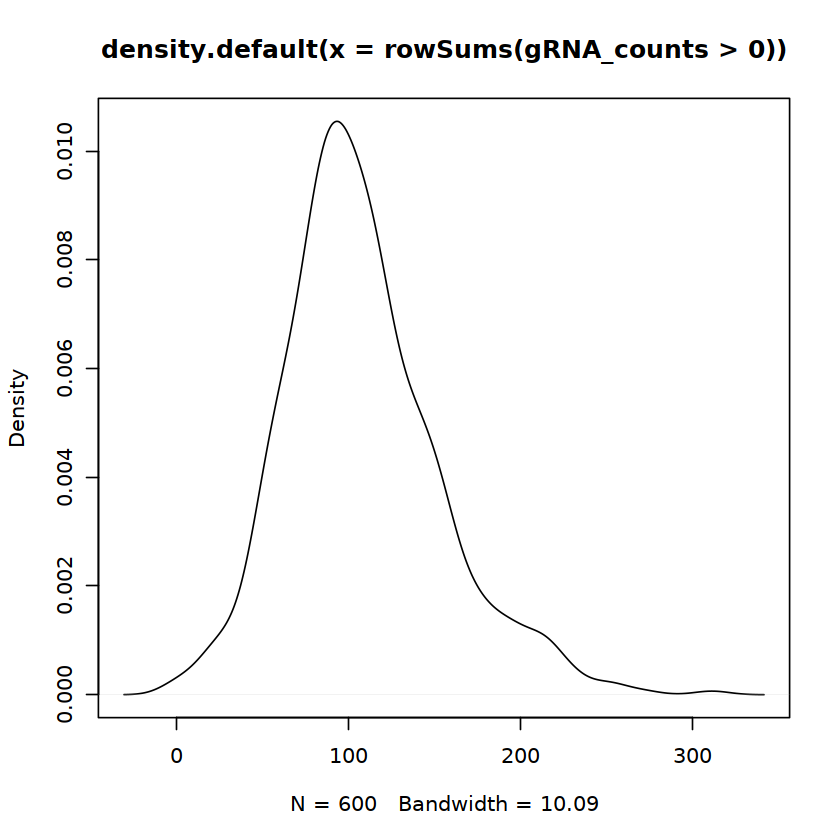

In [16]:
plot(density(rowSums(gRNA_counts>0)))

In [17]:
# make empty data frame of correct dimensions
protospacer_calls_df <- data.frame(matrix(ncol=2,nrow=ncol(KO150), dimnames=list(colnames(KO150), c("guide_call", "KO_call"))))

In [18]:
# make assignment
for (barcode in rownames(protospacer_calls_df)){
    
    if (sum(gRNA_counts[,barcode]>0)==1){
        protospacer_calls_df[barcode,"guide_call"] <- rownames(gRNA_counts)[gRNA_counts[,barcode]>0]
        protospacer_calls_df[barcode,"KO_call"] <- substr(protospacer_calls_df[barcode,"guide_call"],1,nchar(protospacer_calls_df[barcode,"guide_call"])-2)
    }
    
    if (sum(gRNA_counts[,barcode]>0)>1){
        protospacer_calls_df[barcode,"guide_call"] <- "Multiplet"
        protospacer_calls_df[barcode,"KO_call"] <- "Multiplet"
    }
    
    if (sum(gRNA_counts[,barcode]>0)==0){
        protospacer_calls_df[barcode,"guide_call"] <- "Negative"
        protospacer_calls_df[barcode,"KO_call"] <- "Negative"
    }
}
head(protospacer_calls_df)
dim(protospacer_calls_df)

,guide_call,KO_call
,<chr>,<chr>
A1_AAACCTGAGAATCTCC-1,Chd7-2,Chd7
A1_AAACCTGAGCGATGAC-1,Babam1-1,Babam1
A1_AAACCTGAGGATCGCA-1,Negative,Negative
A1_AAACCTGAGTGCCAGA-1,Mov10-4,Mov10
A1_AAACCTGAGTGGAGAA-1,Spi1-1,Spi1
A1_AAACCTGAGTTTAGGA-1,Jmjd1c-3,Jmjd1c


[1] 76344     2

In [19]:
sum(protospacer_calls_df$KO_call=="Negative")

[1] 30716

In [20]:
sum(protospacer_calls_df$KO_call=="Multiplet")

[1] 11507

In [27]:
# check if the barcodes/cell names are exactly the same (including order) before adding information
stopifnot(colnames(KO150)==rownames(protospacer_calls_df))

In [28]:
# add guide & gene assignment info
KO150[["guide_call"]] <- protospacer_calls_df$guide_call
KO150[["KO_call"]] <- protospacer_calls_df$KO_call 

# Upsetplots for basic statistics
python package produces better plots!

https://cran.r-project.org/web/packages/UpSetR/vignettes/basic.usage.html

In [32]:
# make directories if not exist
dir.create(file.path(results_path, 'qc'), showWarnings = FALSE)

In [29]:
KO150$KO_call[KO150$KO_call=='NonTargeting-'] <- 'NonTargeting'

In [55]:
KO150_upset_all <- fastDummies::dummy_cols(KO150[[c("hto_demux","pass_QC","KO_call", "batch", "percent.mt", "nCount_RNA","nFeature_RNA")]])

In [56]:
head(KO150_upset_all)

,hto_demux,pass_QC,KO_call,batch,percent.mt,nCount_RNA,nFeature_RNA,hto_demux_Doublet,hto_demux_HTO-RAW264.7-a_LO28-6h,hto_demux_HTO-RAW264.7-a_LO28-24h,⋯,KO_call_Yy1,batch_A1,batch_A2,batch_A3,batch_B1,batch_B2,batch_B3,batch_C1,batch_C2,batch_C3
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,HTO-RAW264.7-b_untreated,True,Chd7,A1,1.481771,17884,4442,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
2,HTO-RAW264.7-b_untreated,True,Babam1,A1,1.299712,12849,3787,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
3,HTO-RAW264.7-a_untreated,True,Negative,A1,1.127854,21634,4842,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
4,HTO-RAW264.7-b_untreated,True,Mov10,A1,1.201740,14479,3851,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
5,HTO-RAW264.7-b_untreated,True,Spi1,A1,1.031602,13765,3832,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
6,HTO-RAW264.7-c_untreated,True,Jmjd1c,A1,1.096367,22985,5073,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0


In [57]:
# convert pass_QC_False to real QC signal ie removing the ones that are actually hto_Negative OR hto_Doublet, remaining the ones that are only QC negative but nothing else is wrong
KO150_upset_all[KO150_upset_all$pass_QC_False==1 & (KO150_upset_all$hto_demux_Negative==1 | KO150_upset_all$hto_demux_Doublet==1),"pass_QC_False"] <- 0

In [45]:
# Upset plot of everything that is removed by QC & assignments
plot_tmp <- upset(KO150_upset_all,
      sets=c("pass_QC_False", "hto_demux_Negative", "hto_demux_Doublet", "KO_call_Multiplet", "KO_call_Negative"),
      boxplot.summary=c("percent.mt","nCount_RNA"),
#        nintersects = NA,
      keep.order = TRUE,
      mb.ratio = c(0.55, 0.45),
     mainbar.y.label = "Number of Cells", 
      sets.x.label = "Number of Cells",
      order.by = "freq",
      group.by="sets",
     )

pdf(file=file.path(results_path,"qc",paste0("KO150_","Upsetplot","_","QC", ".pdf")), onefile=FALSE)
plot_tmp
dev.off()

Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”
Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


png 
  2

In [71]:
KO150_upset_batch <- KO150_upset_all[
    KO150_upset_all$pass_QC_False==1 | 
    KO150_upset_all$hto_demux_Negative==1 | 
    KO150_upset_all$hto_demux_Doublet==1 |
    KO150_upset_all$KO_call_Multiplet==1 |
    KO150_upset_all$KO_call_Negative==1,
]
dim(KO150_upset_batch)

[1] 48064   167

In [82]:
# Upset plot of everything that is removed by QC & assignments including batch information
plot_tmp <- upset(KO150_upset_batch,
      sets=rev(c("pass_QC_False", "hto_demux_Negative", "hto_demux_Doublet", "KO_call_Multiplet", "KO_call_Negative", rev(colnames(KO150_upset_all)[grepl("batch_", colnames(KO150_upset_all))]))),
      boxplot.summary=c("percent.mt","nCount_RNA"),
      keep.order = TRUE,
      mb.ratio = c(0.55, 0.45),
     mainbar.y.label = "Number of Cells", 
      sets.x.label = "Number of Cells",
      order.by = "freq",
      group.by="sets",
    nintersects = 99
     )

pdf(file=file.path(results_path,"qc",paste0("KO150_","Upsetplot","_","QC",'_','batch', ".pdf")), onefile=FALSE, width=20, height=20)
plot_tmp
dev.off()

Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”
Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


png 
  2

In [69]:
KO150_upset_analysis <- KO150_upset_all[
    KO150_upset_all$pass_QC_True==1 & 
    KO150_upset_all$hto_demux_Negative==0 & 
    KO150_upset_all$hto_demux_Doublet==0 &
    KO150_upset_all$KO_call_Multiplet==0 &
    KO150_upset_all$KO_call_Negative==0
    ,!(names(KO150_upset_all) %in% c('hto_demux_Doublet','hto_demux_Negative','pass_QC_False','pass_QC_True','KO_call_Multiplet','KO_call_Negative'))]

dim(KO150_upset_analysis)

[1] 28280   161

In [47]:
# Upsetplot of everything that is used in the analysis
plot_tmp <- upset(KO150_upset_analysis,
      sets=rev(colnames(KO150_upset_analysis)[grepl("KO_call_|hto_demux_", colnames(KO150_upset_analysis))]),
      nsets = length(rev(colnames(KO150_upset_analysis)[grepl("KO_call_|hto_demux_", colnames(KO150_upset_analysis))])),
#       keep.order = T,
      mb.ratio = c(0.45, 0.55),
     mainbar.y.label = "Number of Cells", 
      sets.x.label = "Number of Cells",
      boxplot.summary=c("percent.mt","nCount_RNA"),
      order.by = "freq",
      decreasing = T,
      group.by="sets",
      number.angles = 30,
      nintersects=3*135
     )

pdf(file=file.path(results_path,"qc",paste0("KO150_","Upsetplot","_","analysis", ".pdf")), onefile=FALSE, width=50, height=50)
plot_tmp
dev.off()

Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”
Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


png 
  2

In [28]:
# sub_test <- subset(KO150, subset = hto_demux != 'Doublet' & hto_demux != 'Negative' & pass_QC == 'True' & guide_call!='Negative' & guide_call!='Multiplet')
# sub_test

An object of class Seurat 
31673 features across 28280 samples within 4 assays 
Active assay: gRNA (600 features, 0 variable features)
 3 other assays present: RNA, AB, HTO

# save raw metadata

In [10]:
KO150[['condition']] <- str_split_fixed(KO150$hto_demux, "_", 2)[,2]

In [11]:
KO150$KO_call[KO150$KO_call=='NonTargeting-'] <- 'NonTargeting'

In [12]:
# save raw metadata
write.csv(KO150[[]], file=file.path(results_path,paste0('KO150_raw_metadata','.csv')), row.names=TRUE)

# save & load raw annotated unfiltered Seurat object

In [13]:
# save Seurat object
saveRDS(KO150, file = file.path(results_path,paste0("KO150_raw_annotated_Seurat.rds")))

In [9]:
# loading Seurat object
KO150 <-readRDS(file = file.path(results_path,paste0("KO150_raw_annotated_Seurat.rds")))
KO150

An object of class Seurat 
31673 features across 76344 samples within 4 assays 
Active assay: gRNA (600 features, 0 variable features)
 3 other assays present: RNA, AB, HTO

# filter by HTO, QC and guide assignment

In [78]:
# filter
# subset by QC & guide assignment
KO150 <- subset(KO150, subset = hto_demux != 'Doublet' & hto_demux != 'Negative' & pass_QC == 'True' & guide_call!='Negative' & guide_call!='Multiplet')
KO150

An object of class Seurat 
31673 features across 28303 samples within 4 assays 
Active assay: gRNA (600 features, 0 variable features)
 3 other assays present: RNA, AB, HTO

# save & load filtered Seurat object

In [79]:
# save Seurat object
saveRDS(KO150, file = file.path(results_path,paste0("KO150_filtered_Seurat.rds")))

In [5]:
# loading Seurat object
KO150 <-readRDS(file = file.path(results_path,paste0("KO150_filtered_Seurat.rds")))
KO150

An object of class Seurat 
31673 features across 41541 samples within 4 assays 
Active assay: RNA (31053 features, 0 variable features)
 3 other assays present: AB, gRNA, HTO

# normalize RNA via SCTransform, AB & guideRNA via CLR

In [80]:
dir.create(file.path(results_path,"cellcycle"), showWarnings = FALSE)

In [81]:
DefaultAssay(KO150) 
DefaultAssay(KO150) <- 'RNA'
DefaultAssay(KO150) 

[1] "gRNA"

[1] "RNA"

In [1]:
# run sctransform
KO150 <- SCTransform(KO150, 
                     vars.to.regress = "percent.mt", 
                     verbose = FALSE,
                     method = "glmGamPoi"
                    )#, min_cells = 1)

ERROR: Error in SCTransform(PT149, vars.to.regress = "percent.mt", verbose = FALSE, : could not find function "SCTransform"


In [83]:
mouseHumanGenes <- read.table(file = file.path("resources","HOM_MouseHumanSequence.rpt"), sep = '\t', header = TRUE)

In [84]:
# convert human cell cycle genes to murine genes
m.g2m.genes <- vector()

for (human_gene in cc.genes$g2m.genes){
    tmp_homolo_ID <- mouseHumanGenes[mouseHumanGenes$Symbol==human_gene,'HomoloGene.ID']
    m.g2m.genes <- append(m.g2m.genes, mouseHumanGenes[mouseHumanGenes$HomoloGene.ID==tmp_homolo_ID & mouseHumanGenes$Common.Organism.Name=="mouse, laboratory", "Symbol"])
}

# m.g2m.genes

In [85]:
# convert human cell cycle genes to murine genes
m.s.genes <- vector()

for (human_gene in cc.genes$s.genes){
    tmp_homolo_ID <- mouseHumanGenes[mouseHumanGenes$Symbol==human_gene,'HomoloGene.ID']
    m.s.genes <- append(m.s.genes, mouseHumanGenes[mouseHumanGenes$HomoloGene.ID==tmp_homolo_ID & mouseHumanGenes$Common.Organism.Name=="mouse, laboratory", "Symbol"])
}

# m.s.genes

In [86]:
DefaultAssay(KO150)

[1] "SCT"

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 7 features requested have not been scaled (running reduction without them): Wdr76, Ubr7, Pold3, Msh2, Blm, Casp8ap2, Ctcf”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  Ube2c, Cenpf, Mki67, Cenpa, Top2a, Hmgb2, Cdc20, Tubb4b, Cdk1, Ccnb2 
	   Birc5, Tpx2, Kif23, Cdca8, Aurkb, Cenpe, Aurka, Ckap2l, Anln, Cks1b 
	   Cks2, Smc4, Hmmr, Nusap1, Kif11, Kif20b, Tacc3, Cdca3, Rrm2, Cdca2 
Negative:  Ung, Cdc6, Ccne2, Dscc1, Cdca7, Dtl, Pola1, Exo1, Pcna, Mcm2 
	   Chaf1b, Mcm4, Slbp, Hells, Brip1, Uhrf1, Mcm6, Rfc2, Gins2, Prim1 
	   Cbx5, E2f8, Gas2l3, Rad51, Mcm5, Cdc45, G2e3, Rpa2, Clspn, Gmnn 
PC_ 2 
Positive:  Ube2c, Cdc20, Cenpa, Cenpf, Ccnb2, Aurka, Tubb4b, Cenpe, Hmmr, Cks2 
	   Cdc25c, Kif2c, Tpx2, Psrc1, Nek2, Tacc3, Ckap2, Gas2l3, Kif23, G2e3 
	   Cdca8, Nusa

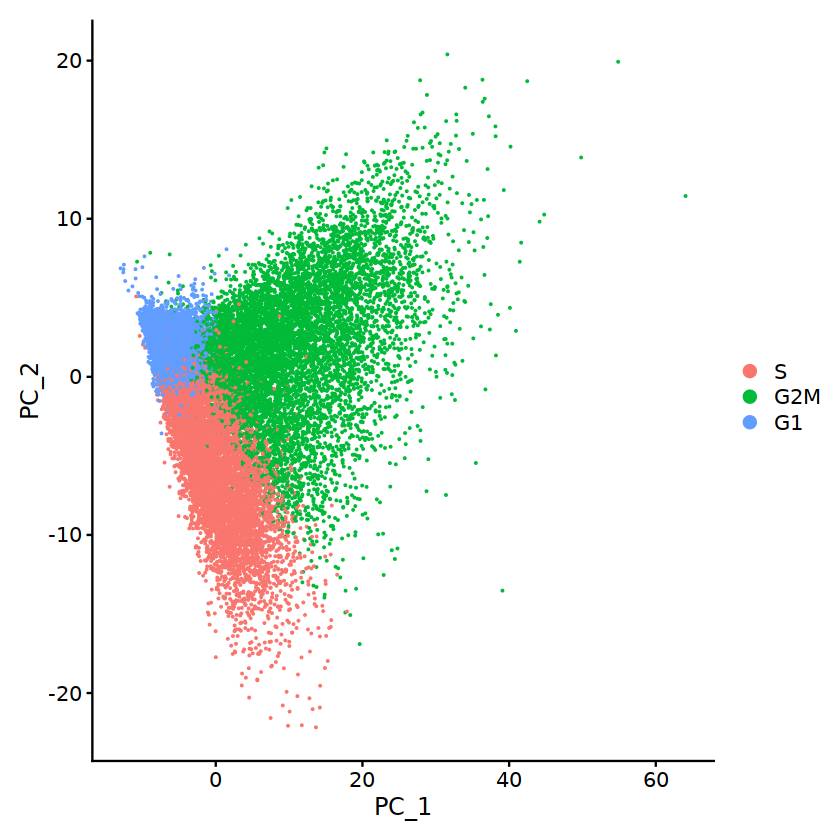

In [87]:
# determine cell cycle scores and plot
s.genes <- m.s.genes
g2m.genes <- m.g2m.genes
KO150 <- CellCycleScoring(KO150, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE) #presumably running on SCT assay, as it is the default Assay
KO150 <- RunPCA(KO150, features = c(s.genes, g2m.genes))
DimPlot(KO150)
ggsave(
  paste0("KO150_","CellCyclePCA","_","preRemoval", ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path,"cellcycle"),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 7 features requested have not been scaled (running reduction without them): Wdr76, Ubr7, Pold3, Msh2, Blm, Casp8ap2, Ctcf”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  Ube2c, Cdc20, Cenpa, Ccnb2, Aurka, Cdk1, Tubb4b, Cks1b, Ung, Tacc3 
	   Cks2, Cdc25c, Hells, Cdca7, Rpa2, Ckap2l, Mcm6, Cdc6, Cdca8, Tipin 
	   Mcm2, Mcm4, Nasp, Kif2c, Mcm5, Ckap2, Dtl, Tpx2, Hmmr, Cenpe 
Negative:  Mki67, Top2a, Atad2, Rrm2, Aurkb, Anln, Kif11, Kif20b, E2f8, Tmpo 
	   Ncapd2, Cdca2, Clspn, Kif23, Rrm1, Cbx5, Hjurp, Smc4, Ckap5, Brip1 
	   Ect2, Cdca3, Ndc80, Pola1, Ttk, Nuf2, Lbr, Bub1, Prim1, Cenpf 
PC_ 2 
Positive:  Ccnb2, Cdc20, Cenpa, Cks1b, Cdca3, Hmgb2, Birc5, Cdca8, Lbr, Cks2 
	   Cdca7, Nasp, Cdc25c, Rangap1, Hmmr, Hells, Ung, Bub1, Tipin, Mcm2 
	   Ckap2, Dlgap5, Psrc1

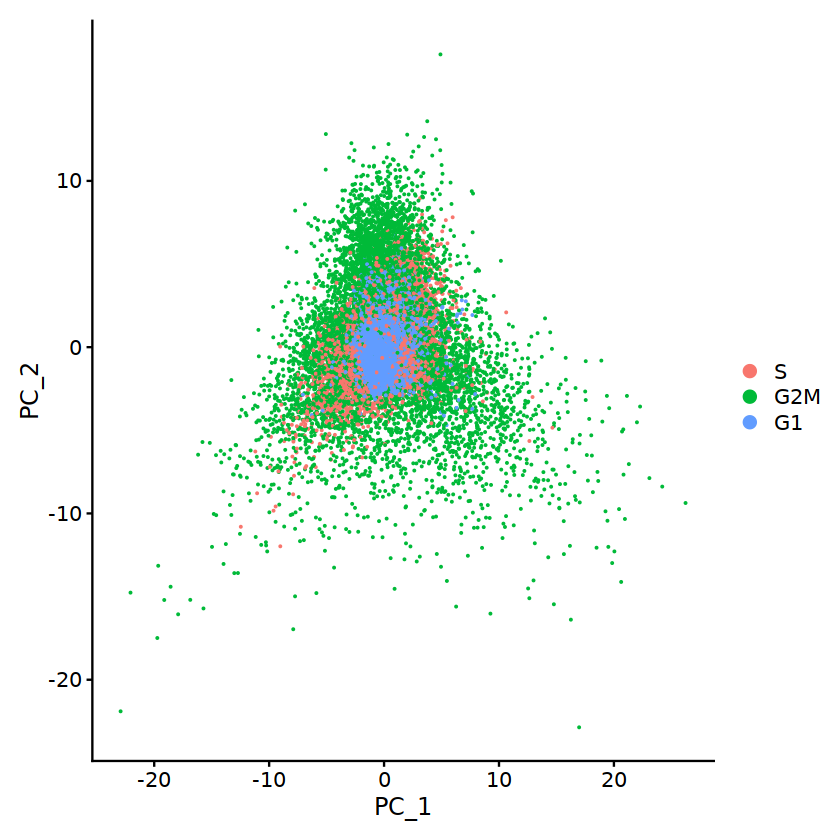

In [88]:
KO150 <- SCTransform(KO150, 
                     vars.to.regress = c("percent.mt", "S.Score", "G2M.Score"), 
                     assay = 'RNA', 
                     new.assay.name = 'SCT', 
                     verbose = FALSE,
                     method="glmGamPoi"
                    )#, min_cells = 1)
KO150 <- RunPCA(KO150, features = c(s.genes, g2m.genes))
DimPlot(KO150)
ggsave(
  paste0("KO150_","CellCyclePCA","_","postRemoval", ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path,"cellcycle"),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [89]:
# normalize Ab data
KO150 <- NormalizeData(KO150, normalization.method = "CLR", margin = 2, assay = "AB")

Normalizing across cells



In [90]:
# normalize guide RNA data
KO150 <- NormalizeData(KO150, normalization.method = "CLR", margin = 2, assay = "gRNA")

Normalizing across cells



# Dimred & plot

In [92]:
dir.create(file.path(results_path,"unsupervised"), showWarnings = FALSE)

In [93]:
# Run PCA & UMAP
KO150 <- RunPCA(KO150, verbose = FALSE)
KO150 <- RunUMAP(KO150, dims = 1:30, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [ ]:
# Plot PCA & UMAP with discrete features (Dimplot)
features <- c("hto_demux", "batch", "KO_call", "Phase")

for (dimred in c("umap", "pca")){
    for (feature in features){
        if (feature=='KO_call'){
                DimPlot(KO150, reduction=dimred, label = FALSE, group.by=feature) + NoLegend()
        }else{
                DimPlot(KO150, reduction=dimred, label = FALSE, group.by=feature)
        }
#         DimPlot(KO150, reduction=dimred, label = FALSE, group.by=feature)
        ggsave(
          paste0("KO150_normalized_",dimred,"_",feature, ".svg"),
          plot = last_plot(),
          device = "svg",
          path = file.path(results_path,"unsupervised"),
          scale = 1,
          dpi = 300,
          limitsize = FALSE,
        )
    }
}

In [17]:
# Plot PCA & UMAP colored by NT and Spi1-KO

KO150$NT_Spi1 <- KO150$KO_call
KO150$NT_Spi1[(KO150$NT_Spi1!='Spi1') & (KO150$NT_Spi1!='NonTargeting')] = 'other'
unique(KO150$NT_Spi1)

for (dimred in c("umap", "pca")){
    DimPlot(KO150, reduction=dimred, label = FALSE, group.by='NT_Spi1', cells = KO150$NT_Spi1!='other')

    ggsave(
      paste0("KO150_normalized_",dimred,"_NT_Spi1-KO", ".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path,"unsupervised"),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
    )
}

[1] "other"        "Spi1"         "NonTargeting"

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [14]:
# Plot PCA & UMAP with continuous features (FeaturePlot)
features <- c("nCount_RNA", "nFeature_RNA", "nCount_AB", 'nFeature_AB','nCount_gRNA','nFeature_gRNA','nCount_HTO','nFeature_HTO','percent.mt')

for (dimred in c("umap", "pca")){
    for (feature in features){
        FeaturePlot(KO150, reduction=dimred, features = feature)
        ggsave(
          paste0("KO150_normalized_",dimred,"_",feature, ".svg"),
          plot = last_plot(),
          device = "svg",
          path = file.path(results_path,"unsupervised"),
          scale = 1,
          dpi = 300,
          limitsize = FALSE,
        )
    }
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [17]:
# Plot PCA & UMAP with all continuous features simultaneously (FeaturePlot)
for (dimred in c("umap", "pca")){
    FeaturePlot(KO150, reduction=dimred, features = features)
    ggsave(
      paste0("KO150_normalized_",dimred,"_all", ".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path,"unsupervised"),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
        width=20,
        height=20
    )
}

In [6]:
# Plot PCA & UMAP with all AB features simultaneously (FeaturePlot)
features <- rownames(GetAssayData(object = KO150, assay='AB', slot = "counts"))

for (dimred in c("umap", "pca")){
    FeaturePlot(KO150, reduction=dimred, features = features)
    ggsave(
      paste0("KO150_AB_normalized_",dimred,"_all", ".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path,"unsupervised"),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
        width=20,
        height=20
    )
}

Warning message:
“Could not find CD115 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD11b in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD274 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD69 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD64 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD163 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD172a in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD14 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD80 in the default search locations, found in AB assay instead”
Warning message:
“Could not find Mac-2 in the default search locations, found in AB assay instead”
Warning messa

# save & load normalized Seurat object

In [94]:
# save Seurat object
saveRDS(KO150, file = file.path(results_path,paste0("KO150_normalized_Seurat.rds")))

In [4]:
# loading Seurat object
KO150 <-readRDS(file = file.path(results_path,paste0("KO150_normalized_Seurat.rds")))
KO150

An object of class Seurat 
48804 features across 28303 samples within 5 assays 
Active assay: SCT (17131 features, 3000 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 2 dimensional reductions calculated: pca, umap

In [5]:
KO150$KO_call[KO150$KO_call=='NonTargeting-'] <- 'NonTargeting'

In [8]:
# save matrix of SCT counts
SCT_counts <- GetAssayData(object = KO150, slot = "counts")
dim(SCT_counts)
write.csv(SCT_counts, file=file.path(results_path,paste0('KO150_SCT_counts','.csv')), row.names=TRUE)

[1] 17131 28303

In [7]:
# save metadata & normalized AB values
slot <- "data"
ab_flag <- "AB"
step <- "NORMALIZED"

# save metadata
write.csv(KO150[[]], file=file.path(results_path, paste0('KO150_',step,"_metadata",".csv")), row.names=TRUE)
# save normalized AB
write.csv(GetAssayData(object = KO150, slot = slot, assay = ab_flag), file=file.path(results_path, paste0('KO150_',step,'_',ab_flag,".csv")), row.names=TRUE)

# make cell count summary

In [9]:
KO150[['condition']] <- str_split_fixed(KO150$hto_demux, "_", 2)[,2]

In [9]:
KO150$KO_call[KO150$KO_call=='NonTargeting-'] <- 'NonTargeting'

In [102]:
cell_numbers_df <- data.frame(matrix(ncol = 3, nrow=length(unique(KO150$KO_call))+1))
rownames(cell_numbers_df) <- c('all',unique(KO150$KO_call))
colnames(cell_numbers_df) <- unique(KO150$condition)

In [104]:
# load, extract and save cell numbers per object
for (condition in unique(KO150$condition)){
#     print(condition)
    
    # fill in sums of all cells
    cell_numbers_df['all',condition] <- sum(KO150$condition==condition)
    
    # fill in NT cells
    cell_numbers_df['NonTargeting', condition] <- sum(KO150$condition==condition & KO150$KO_call=='NonTargeting')
    
    for (KO_gene in unique(KO150$KO_call)){
        if (KO_gene=='NonTargeting'){
            next
        }
        cell_numbers_df[KO_gene, condition] <- sum(KO150$condition==condition & KO150$KO_call==KO_gene)
    }
}

In [127]:
head(cell_numbers_df)

,untreated,LO28-6h,LO28-24h
,<int>,<int>,<int>
all,12176,11578,4549
Chd7,110,113,39
Babam1,100,90,32
Mov10,66,79,17
Spi1,62,59,35
Jmjd1c,67,56,19


In [106]:
write.csv(cell_numbers_df, file=file.path(results_path,paste0('KO150_cell_count_summary','.csv')), row.names=TRUE)

In [109]:
sum(cell_numbers_df==0)

[1] 0

In [110]:
rowSums(cell_numbers_df)[1]

all 
28303

In [124]:
mean(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','NonTargeting')),'untreated'])
mean(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','NonTargeting')),'LO28-6h'])
mean(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','NonTargeting')),'LO28-24h'])

[1] 80.64444

[1] 76.7037

[1] 30.11111

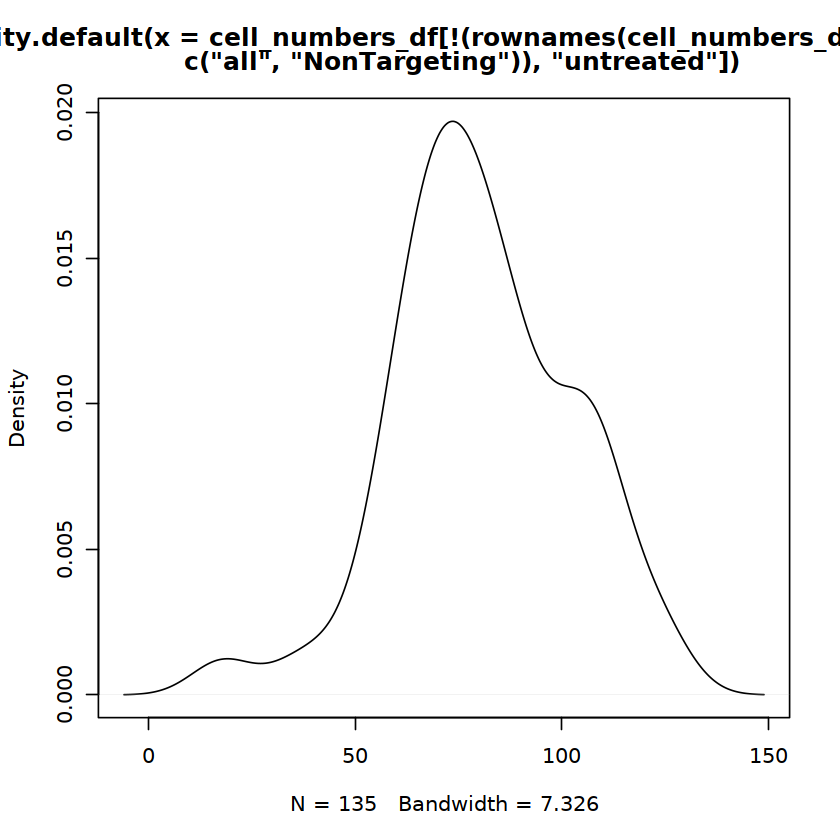

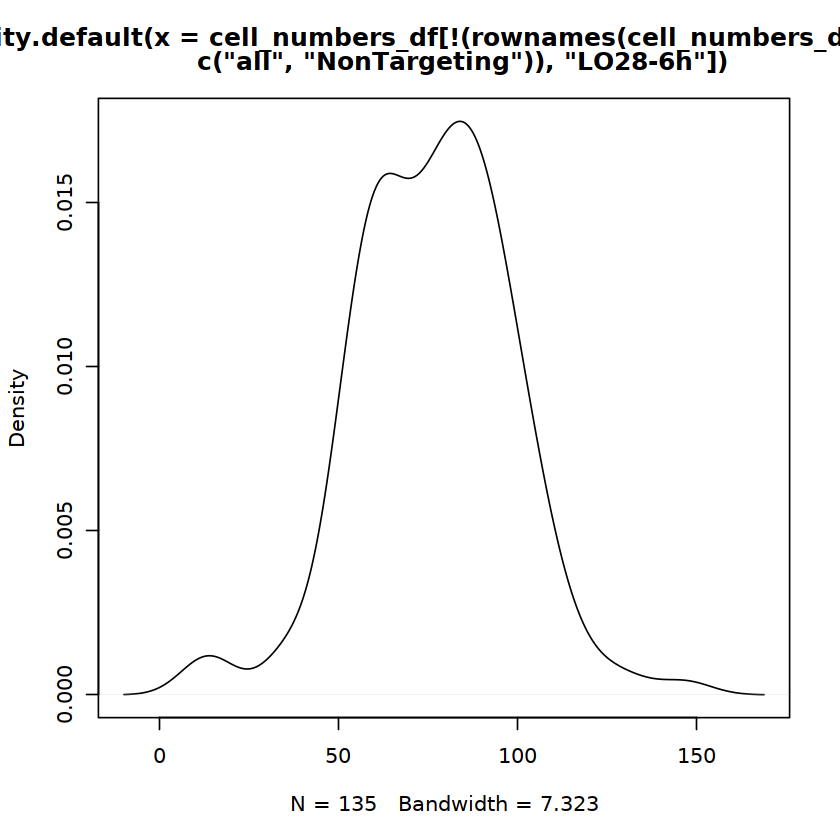

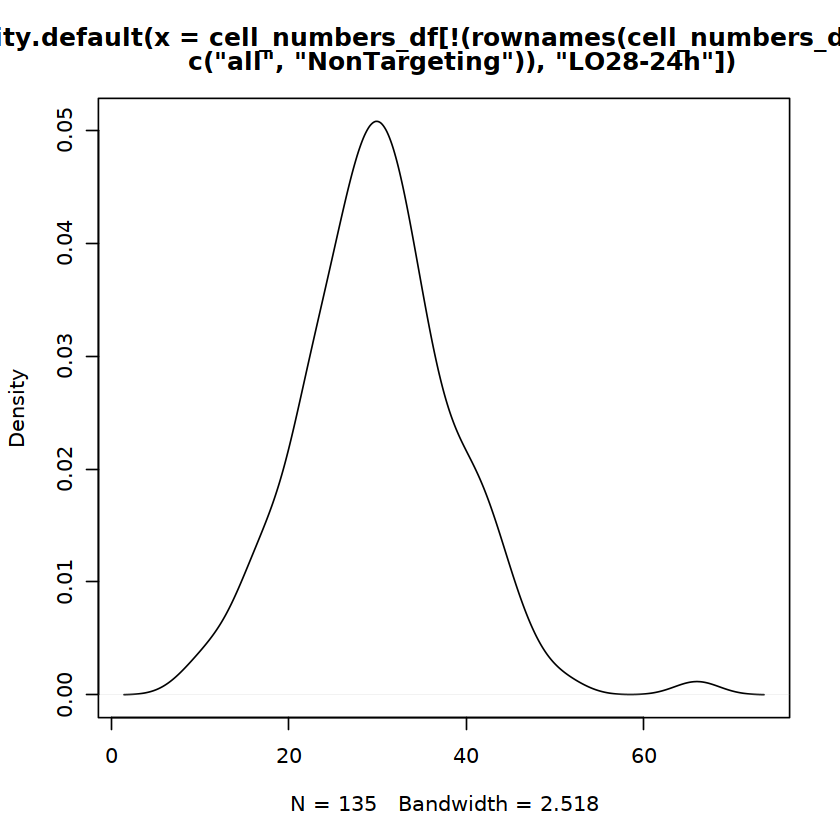

In [126]:
plot(density(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','NonTargeting')),'untreated']))
plot(density(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','NonTargeting')),'LO28-6h']))
plot(density(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','NonTargeting')),'LO28-24h']))

# interactive plot

In [4]:
library(plotly)


Attaching package: ‘plotly’


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




In [12]:
plot <- DimPlot(KO150, reduction='umap', label = FALSE, group.by='condition')
p <- HoverLocator(plot = plot, information = FetchData(KO150, vars = colnames(KO150[[]])))#c("batch", "KO_call", "guide_call", "nFeature_RNA",'nCount_RNA','Phase', 'condition')))

In [13]:
htmlwidgets::saveWidget(as_widget(p), file.path(results_path,"unsupervised","index.html"))

Warning message in if (is.na(col)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(col)) {:
“the condition has length > 1 and only the first element will be used”
Warning message:
“`error_y.color` does not currently support multiple values.”
Warning message:
“`error_x.color` does not currently support multiple values.”
Warning message:
“`line.color` does not currently support multiple values.”
Warning message:
“The titlefont attribute is deprecated. Use title = list(font = ...) instead.”
